In [1]:
import numpy as np
import ase
import spglib
from ase import build
from ase.build import supercells
from uf3.forcefield import lammps
from uf3.forcefield.properties import phonon
from uf3.forcefield.properties import elastic

# Initialize LAMMPS

In [2]:
name = "UF"

In [3]:
if name == "LJ":
    calc = lammps.UFLammps(lmpcmds=["pair_style lj/cut 5.5",
                                    "pair_coeff * * 0.87 2.5"],
                           keep_alive=True)
elif name=="Morse":
    calc = lammps.UFLammps(lmpcmds=["pair_style morse 5.5",
                                    "pair_coeff * * 0.4206 1.4025 3.055"],
                           keep_alive=True)
elif name=="EAM":
    calc = lammps.UFLammps(lmpcmds=["pair_style eam/fs",
                                    "pair_coeff * * potentials/w_eam4.fs W"],
                           keep_alive=True)
elif name=="SNAP":
    calc = lammps.UFLammps(lmpcmds=["pair_style snap",
                                    "pair_coeff * * "
                                    "potentials/snap.snapcoeff "
                                    "potentials/snap.snapparam W W"],
                           keep_alive=True)
elif name=="qSNAP":
    calc = lammps.UFLammps(lmpcmds=["pair_style snap",
                                    "pair_coeff * * "
                                    "potentials/qsnap.snapcoeff "
                                    "potentials/qsnap.snapparam W W"],
                           keep_alive=True)
elif name=="UF":
    calc = lammps.UFLammps(lmpcmds=["pair_style table spline 25",
                                    "pair_coeff * * potentials/uf_w.table"
                                    " UF_W-W 5.5"],
                           keep_alive=True)
elif name=="GAP":
    calc = lammps.UFLammps(lmpcmds=["pair_style quip",
                                    "pair_coeff  * * potentials/gap.xml"
                                    " \"Potential xml_label="
                                    "GAP_2020_10_2_-240_18_49_5_313\" 74"],
                           keep_alive=True)

# Build BCC and relax (2 atoms)

In [4]:
element = 'W'
geom = build.bulk(element, 'bcc', a=3.2, cubic=True)
geom.calc = calc
calc.relax(geom)
print("Relaxation steps:", calc.results['nsteps'])

Relaxation steps: 10


In [5]:
a0 = np.mean(np.diag(geom.cell.array))
print("Lattice constant: {0:.3f} angstroms".format(a0))

Lattice constant: 3.169 angstroms


# Get primitive cell (1 atom)

In [6]:
lattice, scaled_positions, numbers = spglib.standardize_cell(geom,
                                                             to_primitive=True,
                                                             no_idealize=False,
                                                             symprec=1e-5)
geom = ase.Atoms(cell=lattice,
                 scaled_positions=scaled_positions,
                 numbers=numbers,
                 pbc=(True, True, True))

# Get elastic constants

In [7]:
# constants = elastic.get_elastic_constants(geom, calc)
elastic_constants = calc.get_elastic_constants(geom)
print('Cij (GPa):', elastic_constants[:-1])
print('B (GPa):', elastic_constants[-1])

Cij (GPa): [538.6381688435068, 188.94241057186562, 184.96593908729577]
B (GPa): 300.5316980683793


# Get Phonon Spectra

In [8]:
force_constants, path_data, bands_dict = calc.get_phonon_data(geom,
                                                              n_super=9,
                                                              disp=0.05)

In [9]:
dft_ref =[[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.1294, 3.8919, 3.8919, 5.8824],
           [0.2593, 5.1683, 5.1683, 5.1683]],
          [[0.2593, 5.1683, 5.1683, 5.1683],
           [0.3656, 4.4492, 4.4492, 5.9732],
           [0.4718, 3.5877, 4.3710, 6.4989]],
          [[0.4718, 3.5877, 4.3710, 6.4989],
           [0.5466, 2.9536, 2.9536, 4.7921],
           [0.6213, 0.0000, 0.0000, 0.0000]],
          [[0.6213, 0.0000, 0.0000, 0.0000],
           [0.6861, 3.7003, 3.7003, 5.1450],
           [0.751 , 5.3080, 5.3080, 5.3080]],
          [[0.751 , 5.3080, 5.3080, 5.3080],
           [0.8752, 5.1264, 5.6094, 5.6094],
           [1.0000, 5.1531, 5.1531, 5.2941]],
          [[1.0000, 5.1531, 5.1531, 5.2941],
           [1.0641, 4.6197, 5.0059, 5.9081],
           [1.1274, 3.5723, 4.3530, 6.4834]]]
dft_ref = np.array(dft_ref)

distances = bands_dict['distances']
frequencies = bands_dict['frequencies']

residuals = []
for interval_idx in range(len(distances)):
    targets = dft_ref[interval_idx, :, 1:]
    freq = frequencies[interval_idx]
    mid_idx = int(len(freq)/2)

    predictions = np.array([freq[0], freq[mid_idx], freq[-1]])
    deltas = np.subtract(targets, predictions).flatten()**2
    residuals.extend(deltas.tolist())
phonon_rmse = np.sqrt(np.mean(residuals))
print('Phonon RMSE:', phonon_rmse, 'THz')

Phonon RMSE: 0.22988372758478695 THz


(0.0, 7.0)

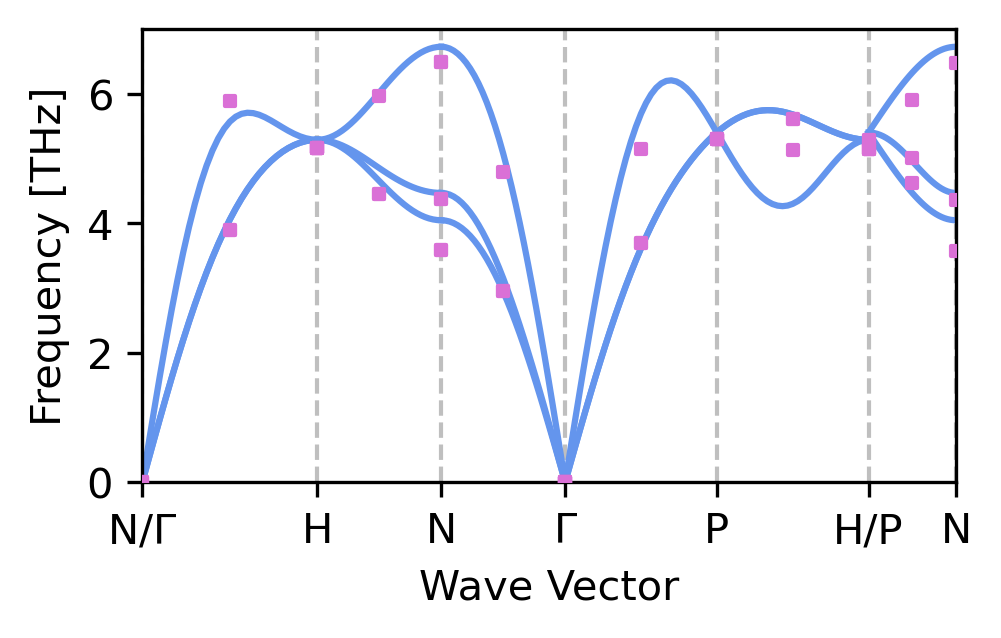

In [10]:
import matplotlib.pyplot as plt
fig, ax = phonon.plot_phonon_spectrum(path_data, bands_dict, color='cornflowerblue')

factor = distances[-1][-1]
for interval_idx in range(len(distances)):
    mid_idx = int(len(freq)/2)
    wv = distances[interval_idx]
    wv = [wv[0], wv[mid_idx], wv[-1]]
    targets = dft_ref[interval_idx, :, 1:].flatten()
    plt.scatter(np.repeat(wv, 3)/factor, targets, color='orchid', s=5, marker='s', zorder=10)
    
ax.set_xlim(0, 1)
ax.set_ylim(0, 7)

# Compute vacancy formation energy

In [11]:
bulk_geom = build.bulk(element, 'bcc', a=a0, cubic=True)
bulk_geom = supercells.make_supercell(bulk_geom, np.eye(3) * [9, 9, 9])
bulk_geom.calc = calc
pristine_energy = bulk_geom.get_potential_energy()
defected_geom = bulk_geom.copy()
del defected_geom[0]
defected_geom.translate([a0*5, a0*5, a0*5])
defected_geom.calc = calc
defected_energy = defected_geom.get_potential_energy()
vacancy_energy = (defected_energy - pristine_energy) / 2
print("Vacancy energy:", vacancy_energy, "eV")

Vacancy energy: 3.8041327035107315 eV


# Compute surface energies

In [12]:
bulk100 = build.bulk(element, a=a0, cubic=True)
bulk100 = supercells.make_supercell(bulk100, np.eye(3) * [4,4,3])
slab100 = build.bcc100(
    element, a=a0, size=(2,2,3), vacuum=15.0, orthogonal=True)
slab110 = build.bcc110(
    element, a=a0, size=(2,2,3), vacuum=15.0, orthogonal=True)
slab111 = build.bcc111(
    element, a=a0, size=(2,2,3), vacuum=15.0, orthogonal=True)
bulk100.calc = calc
slab100.calc = calc
slab110.calc = calc
slab111.calc = calc

In [13]:
# Evaluate energies
e100 = bulk100.get_potential_energy() / 8
s100 = slab100.get_potential_energy()
s110 = slab110.get_potential_energy()
s111 = slab111.get_potential_energy()
# Get surface area
area100 = np.linalg.norm(np.cross(*slab100.get_cell().array[:2]), 2)
area110 = np.linalg.norm(np.cross(*slab110.get_cell().array[:2]), 2)
area111 = np.linalg.norm(np.cross(*slab111.get_cell().array[:2]), 2)
# Normalize energies
energy100 = (s100 - e100)/area100/2
energy110 = (s110 - e100)/area110/2
energy111 = (s111 - e100)/area111/2
# Print
print("100 Surface Energy:", energy100, "eV")
print("110 Surface Energy:", energy110, "eV")
print("111 Surface Energy:", energy111, "eV")

100 Surface Energy: 0.17257520243921687 eV
110 Surface Energy: 0.1608622273191137 eV
111 Surface Energy: 0.19025756000412553 eV


# Cleanup LAMMPS

In [14]:
del calc